In [1]:
# import Google earth engine module
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import geemap
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import ee
import folium
import time
import geopandas as gpd
import pandas as pd
import sklearn
import scipy
from sklearn.linear_model import LinearRegression
import progressbar
from time import sleep
from scipy.stats import pearsonr
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib
import seaborn as sns
#Authenticate the Google earth engine with google account
ee.Initialize()

# Plot regression. O = Observation and P = Prediction
def plot_regression(O, P):
    plt.figure(figsize = (6, 6))
    plt.grid(zorder = 1)
    plt.scatter(O, P, edgecolor='black', linewidth=1, zorder = 2)
    corr, _ = pearsonr(O, P)
    regmodel = LinearRegression()
    regmodel.fit(O.values.reshape(-1,1), P)
    rsq = regmodel.score(O.values.reshape(-1,1), P)
    plt.plot(O.values.reshape(-1,1), regmodel.predict(O.values.reshape(-1,1)), color = 'orange', linestyle = '--', zorder = 3)
    plt.legend([u'Pearson R\u00b2: {:.3f} &\nPearson R: {:.3f}'.format(corr**2, corr), '1:1 Plot', 'Observed - Predicted'])
    plt.xlabel('In situ Precipitation [mm/month]')
    plt.ylabel('Satelite Precipitation [mm/month]')

def p2r(point, area_size = 0.2, field_size = 0.0001):
    area = {
      "type": "FeatureCollection",
      "features": [
        {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "type": "Polygon",
            "coordinates": [
              [
                [
                  point[0] - area_size/2,
                  point[1] - area_size/2
                ],
                [
                  point[0] + area_size/2,
                  point[1] - area_size/2
                ],
                [
                  point[0] + area_size/2,
                  point[1] + area_size/2
                ],
                [
                  point[0] - area_size/2,
                  point[1] + area_size/2
                ],
                [
                  point[0] - area_size/2,
                  point[1] - area_size/2
                ]
              ]
            ]
          }
        }
      ]
    }

    soccer = {
      "type": "FeatureCollection",
      "features": [
        {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "type": "Polygon",
            "coordinates": [
              [
                [
                  point[0] - field_size/2,
                  point[1] - field_size/2
                ],
                [
                  point[0] + field_size/2,
                  point[1] - field_size/2
                ],
                [
                  point[0] + field_size/2,
                  point[1] + field_size/2
                ],
                [
                  point[0] - field_size/2,
                  point[1] + field_size/2
                ],
                [
                  point[0] - field_size/2,
                  point[1] - field_size/2
                ]
              ]
            ]
          }
        }
      ]
    }
    coords_area = area['features'][0]['geometry']['coordinates']
    aoi_area = ee.Geometry.Polygon(coords_area)
    coords_soccer = soccer['features'][0]['geometry']['coordinates']
    aoi_soccer = ee.Geometry.Polygon(coords_soccer)
    return(aoi_area, aoi_soccer)

def GEE(date_start, date_stop, image_coll, area, patch, dist, band2, export = False):
#     patch = patch.buffer(dist)
    
    im_coll = dataset = ee.ImageCollection(image_coll).filterDate(ee.Date(date_start),ee.Date(date_stop)).select(band2)

    acq_times = im_coll.aggregate_array('system:time_start').getInfo()
    avalaible_dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]
    im_list = im_coll.toList(im_coll.size())
    
    variable_list = ee.List([])
    variable_list_VAR = ee.List([])
   
    def reduce_dataset_region(image, list):
        local_image = image.reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=patch,
            scale=1,
            crs = "epsg:4326")

        return ee.List(list).add(local_image)
    
    def reduce_dataset_region_VAR(image, list):
        local_image = image.reduceRegion(
            reducer=ee.Reducer.variance(),
            geometry=patch,
            scale=1,
            crs = "epsg:4326")

        return ee.List(list).add(local_image)
    
    reduced_dataset = im_coll.iterate(reduce_dataset_region, variable_list)
    reduced_dataset_VAR = im_coll.iterate(reduce_dataset_region_VAR, variable_list_VAR)
    
    reduced_dataset_dict = reduced_dataset.getInfo()
    reduced_dataset_dict_VAR = reduced_dataset_VAR.getInfo()
    df1 = pd.DataFrame(data = reduced_dataset_dict, index = avalaible_dates, columns = [band2]).dropna()
    df2 = pd.DataFrame(reduced_dataset_dict_VAR).dropna()
    df1['Variance'] = df2.values
    df1.index = pd.to_datetime(df1.index)
#     df1.index = (df1.index).strftime("%d/%m/%y")
    if export:
        out_dir_col = os.path.join(os.path.expanduser('~'), 'Downloads')
        geemap.ee_export_image_collection(im_coll, region=area, scale=1, out_dir=out_dir_col)
    return df1

In [2]:
df = pd.read_excel('auth.xlsx', engine='openpyxl', parse_dates = True, index_col = 0)
monthly = df.resample('M').sum()

In [3]:
aoi_area, aoi_soccer = p2r([22.996948957443237, 40.538248160360965])

date_start = '2008-01-01'
date_stop = '2020-12-31'
image_coll = "NASA/GPM_L3/IMERG_MONTHLY_V06"
band2 = 'precipitation'

GPM = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [4]:
image_coll = "TRMM/3B43V7"
band2 = 'precipitation'

TRMM = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [20]:
image_coll = "NOAA/PERSIANN-CDR"
band2 = 'precipitation'

date_start = '2008-01-01'
date_stop = '2010-12-31'
PERSIANN_A = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [21]:
date_start = '2011-01-01'
date_stop = '2013-12-31'
PERSIANN_B = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [22]:
date_start = '2014-01-01'
date_stop = '2016-12-31'
PERSIANN_C = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [23]:
date_start = '2017-01-01'
date_stop = '2019-12-31'
PERSIANN_D = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [24]:
date_start = '2020-01-01'
date_stop = '2020-12-31'
PERSIANN_E = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [5]:
image_coll = "ECMWF/ERA5/MONTHLY"
band2 = 'total_precipitation'

ECMWF = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

In [10]:
image_coll = 'UCSB-CHG/CHIRPS/PENTAD'
band2 = 'precipitation'

CHIRPS = GEE(date_start, date_stop, image_coll, aoi_area, aoi_soccer, -10, band2, export = False)

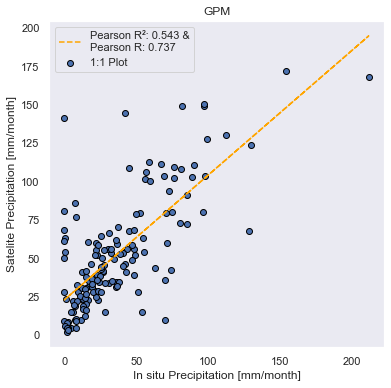

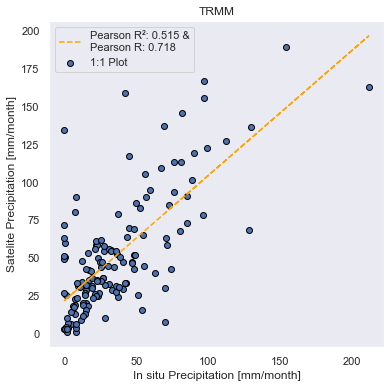

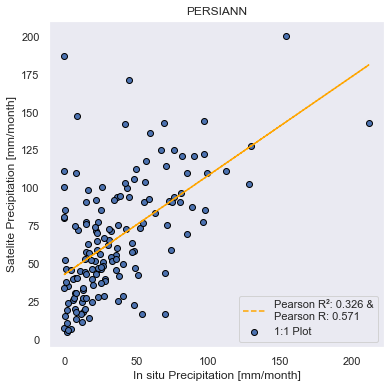

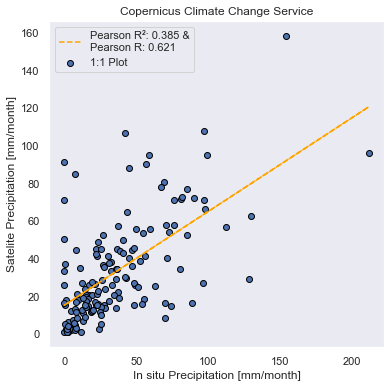

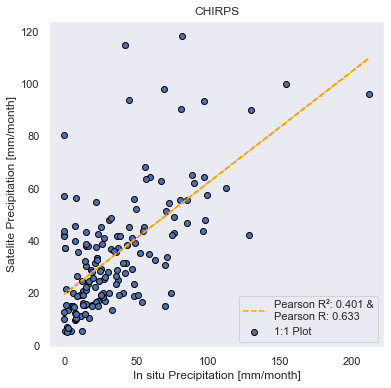

In [113]:
# finals = pd.merge(df['P'], exported, left_index=True, right_index=True).resample('M').sum()
# finals = pd.merge(df['P'], exported, left_index=True, right_index=True)
GPM_df = pd.merge(monthly['P'], GPM.resample('M').sum(), left_index=True, right_index=True)
GPM_df['Product'] = 'GPM'
GPM_df['precipitation'] = GPM_df['precipitation']*24*30
TRMM_df = pd.merge(monthly['P'], TRMM.resample('M').sum(), left_index=True, right_index=True)
TRMM_df['Product'] = 'TRMM {}'.format('1')
TRMM_df['precipitation'] = TRMM_df['precipitation']*24*30
ECMWF.columns = ['precipitation', 'Variance']
ECMWF_df = pd.merge(monthly['P'], ECMWF.resample('M').sum(), left_index=True, right_index=True)
ECMWF_df['Product'] = 'ECMWF'
ECMWF_df['precipitation'] = ECMWF_df['precipitation']*24*30
CHIRPS_df = pd.merge(monthly['P'], CHIRPS.resample('M').sum(), left_index=True, right_index=True)
CHIRPS_df['Product'] = 'CHIRPS'
PERSIANN = PERSIANN_A.append([PERSIANN_B, PERSIANN_C, PERSIANN_D, PERSIANN_E])
PERSIANN_df = pd.merge(monthly['P'], PERSIANN.resample('M').sum(), left_index=True, right_index=True)
PERSIANN_df['Product'] = 'PERSIANN'

gpm = plot_regression(GPM_df['P'], GPM_df['precipitation'])
plt.title('GPM')
trmm = plot_regression(TRMM_df['P'], TRMM_df['precipitation'])
plt.title('TRMM')
persiann = plot_regression(PERSIANN_df['P'], PERSIANN_df['precipitation'])
plt.title('PERSIANN')
ecmwf = plot_regression(ECMWF_df['P'], ECMWF_df['precipitation'])
plt.title('Copernicus Climate Change Service')
chirps = plot_regression(CHIRPS_df['P'], CHIRPS_df['precipitation'])
plt.title('CHIRPS');

rainfall = GPM_df.append([TRMM_df, ECMWF_df, CHIRPS_df, PERSIANN_df])

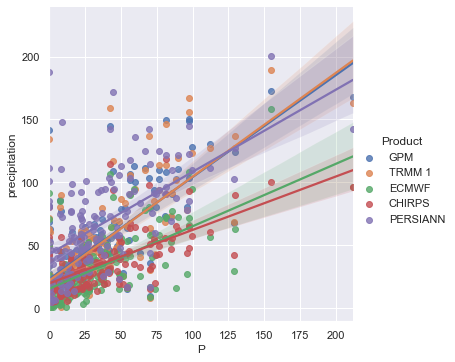

In [119]:
sns.lmplot(x = 'P', y = 'precipitation', hue = 'Product', data = rainfall);